In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier,export_graphviz
from IPython.display import display
import graphviz

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
count = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/18.video_sharing/video_count.csv', parse_dates=['date'])
count.head()

,video_id,count,date
0,2303,22,2015-01-07
1,1193,54854,2015-01-12
2,1219,1788779,2015-01-03
3,1472,234,2015-01-04
4,2947,14407,2015-01-08


In [3]:
count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41775 entries, 0 to 41774
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   video_id  41775 non-null  int64         
 1   count     41775 non-null  int64         
 2   date      41775 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 979.2 KB


In [4]:
features = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/18.video_sharing/video_features.csv', parse_dates=['video_upload_date'])
features.head()

,video_id,video_length,video_language,video_upload_date,video_quality
0,2374,1760,Cn,2014-12-06,480p
1,1897,489,Cn,2014-12-10,720p
2,2386,1273,Es,2014-12-05,480p
3,2912,986,Es,2014-12-10,240p
4,2432,1050,Other,2014-12-10,480p


In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   video_id           2785 non-null   int64         
 1   video_length       2785 non-null   int64         
 2   video_language     2785 non-null   object        
 3   video_upload_date  2785 non-null   datetime64[ns]
 4   video_quality      2785 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 108.9+ KB


In [6]:
data = pd.merge(left=count, right=features, on='video_id', how='left')

data.head()

,video_id,count,date,video_length,video_language,video_upload_date,video_quality
0,2303,22,2015-01-07,1071,Cn,2014-12-10,1080p
1,1193,54854,2015-01-12,770,Other,2014-12-07,720p
2,1219,1788779,2015-01-03,904,Cn,2014-12-12,240p
3,1472,234,2015-01-04,157,Other,2014-12-10,240p
4,2947,14407,2015-01-08,446,Cn,2014-12-19,480p


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41775 entries, 0 to 41774
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   video_id           41775 non-null  int64         
 1   count              41775 non-null  int64         
 2   date               41775 non-null  datetime64[ns]
 3   video_length       41775 non-null  int64         
 4   video_language     41775 non-null  object        
 5   video_upload_date  41775 non-null  datetime64[ns]
 6   video_quality      41775 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 2.5+ MB


### Question 1
Classify each video into one the 3 categories below and explain your approach:

    - "Hot" - means trending up. These videos are candidate to be shown.
    - "Stable and Popular" - video view counts are flat, but very high. These videos are candidates to be shown too.
    - "Everything else" - these videos won't be shown.

In [8]:
data['video_id'].nunique()

2785

In [9]:
def parse_data(df):
    """ function to calculate the statistics for """
    counts = df.sort_values(by='date')['count'].values
    change = (counts[1:] - counts[:-1]) / counts[:-1]
    
    index = ['ct_mean', 'ct_std', 'ct_min', 'ct_25%', 'ct_50%', 'ct_75%', 'ct_max', 
             'cg_mean', 'cg_std', 'cg_min', 'cg_25%', 'cg_50%', 'cg_75%', 'cg_max']
    
    ct_vals = pd.Series(counts).describe()
    cg_vals = pd.Series(change).describe()
    
    ct_values = [ct_vals['mean'], ct_vals['std'], ct_vals['min'], ct_vals['25%'], 
                 ct_vals['50%'], ct_vals['75%'], ct_vals['max']]
    cg_values = [cg_vals['mean'], cg_vals['std'], cg_vals['min'], cg_vals['25%'], 
                 cg_vals['50%'], cg_vals['75%'], cg_vals['max']]
    
    return pd.Series(ct_values + cg_values, index=index)

data_stats = data.groupby('video_id').apply(parse_data)
data_stats.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
1,7.063560e+04,39200.460092,19382.0,41099.0,65907.0,96335.0,140460.0,-0.127437,0.092392,-0.271522,-0.186381,-0.151384,-0.067977,0.030277
2,1.737141e+06,114254.355156,1550493.0,1673415.5,1718352.0,1782226.5,2011096.0,-0.014184,0.061794,-0.084904,-0.061459,-0.043876,0.030687,0.095038
3,2.292781e+06,218636.897779,2016210.0,2132336.5,2247587.0,2436222.5,2653063.0,0.008923,0.054069,-0.075863,-0.028293,-0.001068,0.056393,0.097053
4,2.740392e+06,169611.440727,2474228.0,2611162.0,2719547.0,2880268.5,2984146.0,0.011310,0.050495,-0.063991,-0.027125,0.001606,0.050860,0.090804
5,4.479973e+05,237137.305768,169730.0,255574.5,388594.0,609508.0,983058.0,-0.111811,0.107193,-0.269337,-0.177432,-0.133447,-0.012729,0.031766


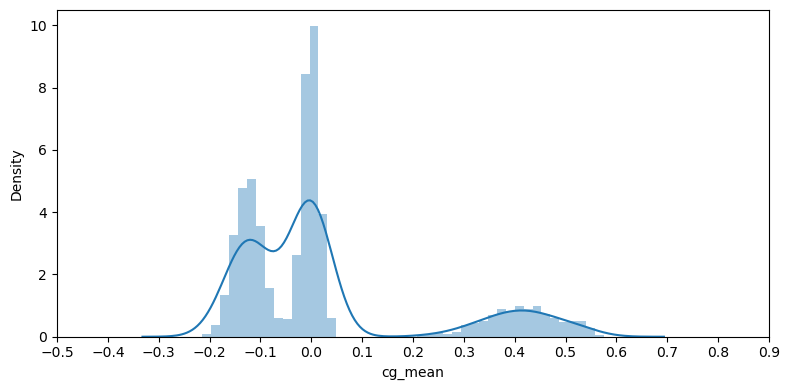

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(data_stats['cg_mean'], ax=ax)
plt.xticks(np.arange(-0.5,1,0.1))
plt.tight_layout()
plt.show()

We can see the average 'rate of change' can clearly split videos into three groups:

- "Hot" - means trending up. These videos are candidate to be shown. We define its average 'rate of change' is over 0.2.
- "Stable and Popular" - video view counts are flat, but very high. These videos are candidates to be shown too. We define its average 'rate of change' is between -0.05 to 0.05.
- "Everything else" - these videos won't be shown. We define its average 'rate of change' is under -0.05.

In [11]:
len(data_stats[data_stats['cg_mean'] >= 0.2]) / len(data_stats)

0.17953321364452424

In [12]:
(len(data_stats)-len(data_stats[data_stats['cg_mean'] >= 0.2])-len(data_stats[data_stats['cg_mean'] < -0.05])) / len(data_stats)

0.45673249551166967

In [13]:
len(data_stats[data_stats['cg_mean'] < -0.05]) / len(data_stats)

0.3637342908438061

In [14]:
category = []
for row in data_stats['cg_mean']:
    if row >= 0.2: 
        category.append('Hot')
    elif row < -0.05:
        category.append('Everything else')
    else:
        category.append('Stable and Popular')

In [15]:
data_stats['category'] = category
data_stats.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max,category
video_id,,,,,,,,,,,,,,,
1,7.063560e+04,39200.460092,19382.0,41099.0,65907.0,96335.0,140460.0,-0.127437,0.092392,-0.271522,-0.186381,-0.151384,-0.067977,0.030277,Everything else
2,1.737141e+06,114254.355156,1550493.0,1673415.5,1718352.0,1782226.5,2011096.0,-0.014184,0.061794,-0.084904,-0.061459,-0.043876,0.030687,0.095038,Stable and Popular
3,2.292781e+06,218636.897779,2016210.0,2132336.5,2247587.0,2436222.5,2653063.0,0.008923,0.054069,-0.075863,-0.028293,-0.001068,0.056393,0.097053,Stable and Popular
4,2.740392e+06,169611.440727,2474228.0,2611162.0,2719547.0,2880268.5,2984146.0,0.011310,0.050495,-0.063991,-0.027125,0.001606,0.050860,0.090804,Stable and Popular
5,4.479973e+05,237137.305768,169730.0,255574.5,388594.0,609508.0,983058.0,-0.111811,0.107193,-0.269337,-0.177432,-0.133447,-0.012729,0.031766,Everything else


In [16]:
data_stats = data_stats.reset_index()

In [17]:
data_merge = pd.merge(features, data_stats[['video_id','category']], on='video_id', how='left')

data_merge.head()

,video_id,video_length,video_language,video_upload_date,video_quality,category
0,2374,1760,Cn,2014-12-06,480p,Everything else
1,1897,489,Cn,2014-12-10,720p,Stable and Popular
2,2386,1273,Es,2014-12-05,480p,Everything else
3,2912,986,Es,2014-12-10,240p,Everything else
4,2432,1050,Other,2014-12-10,480p,Everything else


In [18]:
data_merge['is_hot'] = np.where(data_merge['category']=='Hot', 1, 0)

### Question 2
What are the main characteristics of the "hot videos"?

In [19]:
data_merge['upload_weekday'] = data_merge.video_upload_date.dt.day_name()
data_merge.head()

,video_id,video_length,video_language,video_upload_date,video_quality,category,is_hot,upload_weekday
0,2374,1760,Cn,2014-12-06,480p,Everything else,0,Saturday
1,1897,489,Cn,2014-12-10,720p,Stable and Popular,0,Wednesday
2,2386,1273,Es,2014-12-05,480p,Everything else,0,Friday
3,2912,986,Es,2014-12-10,240p,Everything else,0,Wednesday
4,2432,1050,Other,2014-12-10,480p,Everything else,0,Wednesday


In [20]:
weekday_hot = data_merge.groupby(by='is_hot').apply(lambda data_merge: data_merge.upload_weekday.value_counts(normalize=True)).unstack()
weekday_hot = weekday_hot.loc[:,["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]]
weekday_hot

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
is_hot,,,,,,,
0,0.100219,0.099781,0.19081,0.210941,0.198249,0.108096,0.091904
1,0.132000,0.174000,0.20200,0.190000,0.112000,0.106000,0.084000


<AxesSubplot:xlabel='is_hot'>

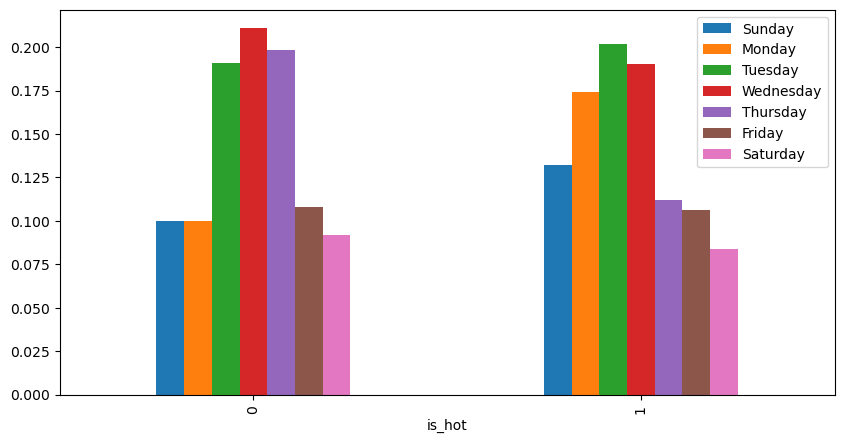

In [21]:
weekday_hot.plot(kind='bar',figsize=(10,5))

From the plot above, we can see that 'Hot' videos usually uploaded on Sunday and Monday.

In [22]:
language_hot = data_merge.groupby(by='is_hot').apply(lambda data_merge: data_merge.video_language.value_counts(normalize=True)).unstack()
language_hot

,Cn,De,En,Es,Fr,Other
is_hot,,,,,,
0,0.301094,0.027571,0.285339,0.131291,0.027133,0.227571
1,0.300000,0.012000,0.368000,0.116000,0.032000,0.172000


<AxesSubplot:xlabel='is_hot'>

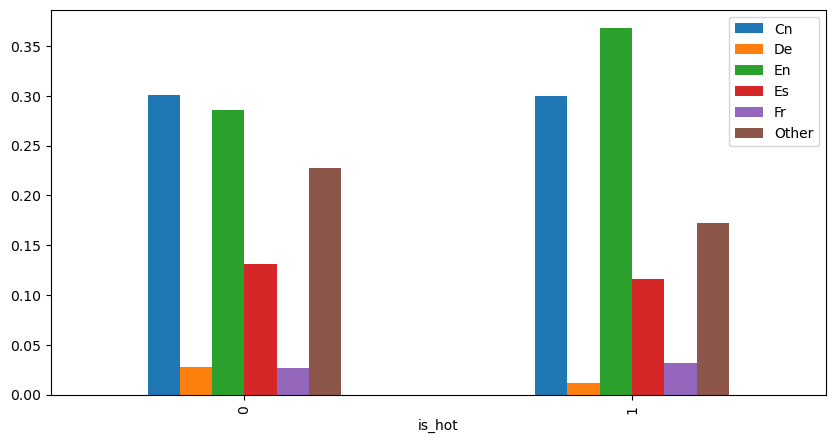

In [23]:
language_hot.plot(kind='bar',figsize=(10,5))

We can see that 'Hot' vidoes are more likely to be in English.

In [24]:
quality_hot = data_merge.groupby(by='is_hot').apply(lambda data_merge: data_merge.video_quality.value_counts(normalize=True)).unstack()
quality_hot

,1080p,240p,360p,480p,720p
is_hot,,,,,
0,0.288403,0.095842,0.154486,0.238512,0.222757
1,0.274000,0.086000,0.140000,0.180000,0.320000


<AxesSubplot:xlabel='is_hot'>

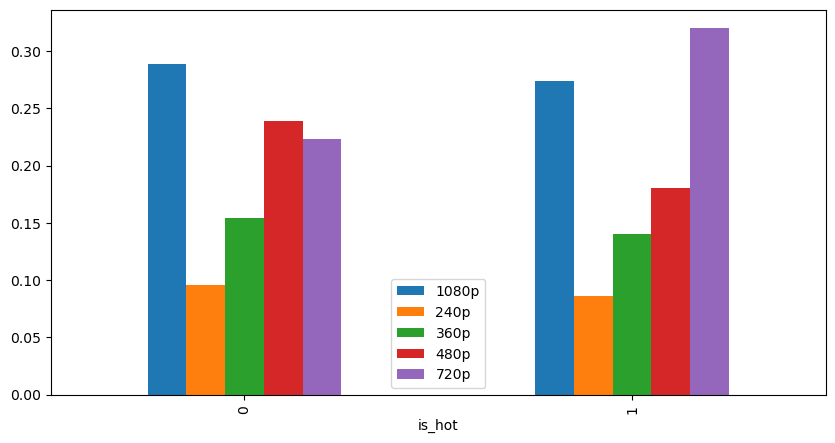

In [25]:
quality_hot.plot(kind='bar',figsize=(10,5))

### Decision Tree

In [26]:
del data_merge['video_upload_date']
del data_merge['category']

data_merge = data_merge.set_index('video_id')

data_merge.head()

,video_length,video_language,video_quality,is_hot,upload_weekday
video_id,,,,,
2374,1760,Cn,480p,0,Saturday
1897,489,Cn,720p,0,Wednesday
2386,1273,Es,480p,0,Friday
2912,986,Es,240p,0,Wednesday
2432,1050,Other,480p,0,Wednesday


In [27]:
y = data_merge.is_hot
del data_merge['is_hot']

In [28]:
X = pd.get_dummies(data_merge,columns=['video_language','video_quality','upload_weekday'],prefix='',prefix_sep='')
X.head()

,video_length,Cn,De,En,Es,Fr,Other,1080p,240p,360p,480p,720p,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
video_id,,,,,,,,,,,,,,,,,,,
2374,1760,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1897,489,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2386,1273,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2912,986,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2432,1050,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [29]:
dt = DecisionTreeClassifier(max_depth=4,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, min_samples_split=20)

In [30]:
feat_importances = pd.Series(dt.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False,inplace=True)
feat_importances

video_length    0.747839
720p            0.101329
Thursday        0.070703
Monday          0.039406
En              0.025902
Sunday          0.013759
Friday          0.001062
480p            0.000000
Tuesday         0.000000
Saturday        0.000000
360p            0.000000
Cn              0.000000
240p            0.000000
1080p           0.000000
Other           0.000000
Fr              0.000000
Es              0.000000
De              0.000000
Wednesday       0.000000
dtype: float64

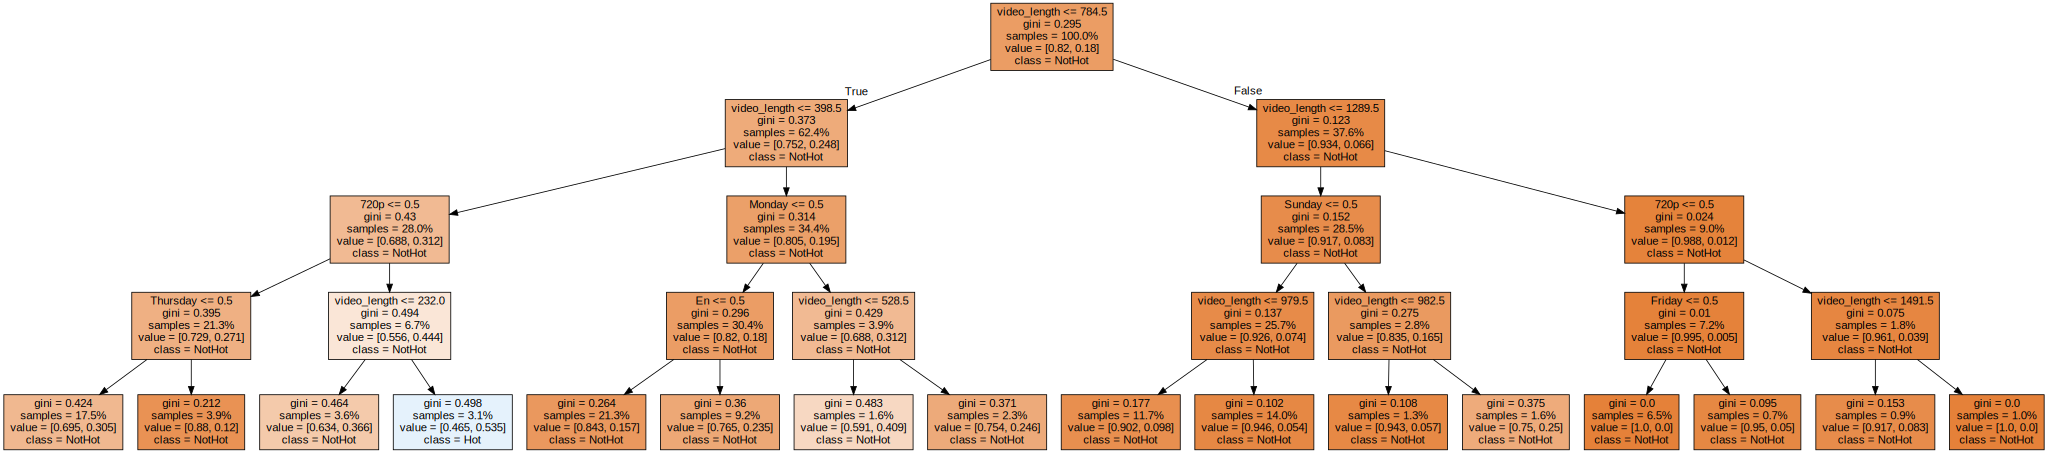

In [31]:
display(graphviz.Source(export_graphviz(dt,feature_names=X.columns,class_names=['NotHot','Hot'],
                proportion=True,leaves_parallel=True,filled=True)))

From above plot, focus on two leaves which have the highest "Hot" ratio.

1. To reach the leave with Hot ratio=0.54 (4th leave from left), the video must be
    - Video_length <= 232.0
    - Not uploaded on Thursday
    - Not uploaded at 720p quality
    
    
2. To reach the leave with Hot ratio=0.41 (7th leave from left), the video must be
    - Video_length <= 528.5
    - English language

### Question 3
After having identified the characteristics of the hot videos, how would you use this information from a product standpoint?

1. We can build a model to predict whether the video will be Hot (trending up) or not. The videos which are predicted to be Hot will be shown on the Home page and attract users to click.


2. Study the reason why videos uploaded on Sunday/Monday are much more likely to be Hot than videos uploaded on Thursday.
    - if the reason is like my guess, is because Sunday/Monday allow the video have longer "offline propagation time"
    - then the problem is why "online propagation" doesn't work well?
    - Is it because our website doesn't have a "Share..." buttion?
    - or is it because we didn't include the most popular social network in our "Share with" list?


3. Study the reason why English videos are more likely to be Hot.
    - is because the translation issue?
    - or maybe we didn't include local social network (such as weibo in China) in our 'Share with' list.